# Anticipate building consumption needs

## <i>Seattle buildings CO2 emissions prediction (part 2)</i>

My mission here for the city of Seattle is to attempt to predict the CO2 emissions and total energy consumption of non-residential buildings for which they have not been measured.

The structural data of the buildings used to fulfill this mission were recorded in 2016 by the city (here their [source](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)).

In the first part we have cleaned our data set, carry out a short exploratory analysis and standardize our data so that they can be used to train different prediction models we chose in this second part to best meet the demand.<br><br>

<u><strong>Summary</strong></u> :<br>
<br>
<strong>Tools </strong> [(here)](#another_cell_0)<br>
 
<strong>II. Seattle buildings CO2 emissions prediction</strong><br>
     -- A. Testing Ridge model [(here)](#another_cell_a)<br>
     -- B. Testing Lasso model [(here)](#another_cell_b)<br>
     -- C. Testing Random Forest model [(here)](#another_cell_c)<br>
     -- D. Testing XGBoost regression model [(here)](#another_cell_d)<br>
     -- E. Train previous models with log transformation of the target variable beforehand [(here)](#another_cell_e)<br>
     -- F. ENERGYSTARScore feature importance in the chosen model [(here)](#another_cell_f)<br>
     -- G. Adding variables and combining variables to improve the performance of the chosen model [(here)](#another_cell_g)<br>
     -- H. Hyperparameter optimization of the selected model [(here)](#another_cell_h)<br>
     -- I. Explain Predictions using SHAP Values [(here)](#another_cell_i)<br>


<strong>Conclusion (part 2) </strong> [(here)](#another_cell_j)

<a id='another_cell_0'></a>

### Tools

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import pingouin as pg
import warnings
import shap

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

In [40]:
# Call initjs() method on shap in order to initialize charts generation using javascript
shap.initjs()

In [4]:
def one_hot_encode_categorical_variables(data, columns):
    # Select the categorical columns
    categorical_data = data[columns]

    # Create an instance of OneHotEncoder
    encoder = OneHotEncoder(sparse=False)

    # Fit and transform the data
    encoded_data = encoder.fit_transform(categorical_data)

    # Create column names for the encoded variables
    encoded_column_names = encoder.get_feature_names(columns)

    # Create a DataFrame for the encoded variables
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)

    # Reset index for both dataframes
    data.reset_index(drop=True, inplace=True)
    encoded_df.reset_index(drop=True, inplace=True)

    # Concatenate the original DataFrame with the encoded DataFrame
    data = pd.concat([data, encoded_df], axis=1)
    
    # Drop the original categorical columns
    data = data.drop(columns=columns)

    return data

In [5]:
data = pd.read_csv("export_building_energy_bench_data.csv", sep=";", index_col=0)
data = data.drop('OSEBuildingID', axis=1)

In [6]:
data.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),GHGEmissionsIntensity,ENERGYSTARScore,BuildingType_Campus,BuildingType_NonResidential,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,0.234783,-0.057573,1.199873,-0.102490,0.129743,0.058118,0.522803,0.440595,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.834783,-0.057573,1.047591,-0.051631,0.311062,0.006468,0.535641,0.466434,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.600000,-0.057573,5.616052,2.813796,0.308395,0.354565,0.248924,0.001335,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.226087,-0.057573,0.895309,-0.193621,0.516379,0.246424,1.310203,0.337240,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.695652,-0.057573,2.113565,0.190410,0.588374,0.201230,0.544199,0.828178,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1665 entries, 0 to 1664
Data columns (total 54 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   YearBuilt                                        1665 non-null   float64
 1   NumberofBuildings                                1665 non-null   float64
 2   NumberofFloors                                   1665 non-null   float64
 3   PropertyGFATotal                                 1665 non-null   float64
 4   SiteEUIWN(kBtu/sf)                               1665 non-null   float64
 5   SourceEUIWN(kBtu/sf)                             1665 non-null   float64
 6   GHGEmissionsIntensity                            1665 non-null   float64
 7   ENERGYSTARScore                                  1665 non-null   float64
 8   BuildingType_Campus                              1665 non-null   float64
 9   BuildingType_NonResidential   

In [8]:
# Define characteristic values X and target value Y
x = data.drop('GHGEmissionsIntensity', axis=1)
y = data['GHGEmissionsIntensity']

# Dataset splitting (0,75/0,25 by default)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

## II. Seattle buildings CO2 emissions prediction

<a id='another_cell_a'></a>

### A. Testing Ridge model

These regularized regression techniques are useful here because we have a large number of features in our data set. They manage multicollinearity selecting the most applicable characteristics.

In [9]:
# Create an instance of the Ridge model
ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0]) #values of the regularization parameter alpha to be tested

# Train the model on the training data
ridge_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_ridge = ridge_model.predict(x_test)

# Root mean square error (RMSE)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)

# R²
r2_score_ridge = ridge_model.score(x_test, y_test)

print("Optimal value of alpha for Ridge model :", ridge_model.alpha_)
print("Ridge RMSE: ", round(rmse_ridge, 2))
print("Ridge R²:", round(r2_score_ridge, 2))

Optimal value of alpha for Ridge model : 10.0
Ridge RMSE:  0.68
Ridge R²: 0.62


<div class="alert-warning">
☛ The RMSE gives a measure of the average error of the model and is here estimated at 0.68, which is a lot.<br>
☛ The R² gives an indication of the variation of the target values that the model is able to explain and is here estimated at 0.62, which seems too low.<br>
<strong>The performance of the Ridge model is therefore rather weak here.</strong>
</div>

<a id='another_cell_b'></a> 

### B. Testing Lasso model

These regularized regression techniques are useful here because we have a large number of features in our data set. They manage multicollinearity selecting the most applicable characteristics.

In [10]:
# Create an instance of the Lasso model
lasso_model = LassoCV(alphas=[0.1, 1.0, 10.0]) #values of the regularization parameter alpha to be tested

# Train the model on the training data
lasso_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_lasso = lasso_model.predict(x_test)

# Root mean square error (RMSE)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)

# R²
r2_score_lasso = lasso_model.score(x_test, y_test)

print("Optimal value of alpha for Lasso model :", lasso_model.alpha_)
print("Lasso RMSE: ", round(rmse_lasso, 2))
print("Lasso R²:", round(r2_score_lasso, 2))

Optimal value of alpha for Lasso model : 0.1
Lasso RMSE:  0.89
Lasso R²: 0.36


<div class="alert-warning">
☛ The RMSE gives a measure of the average error of the model and is here estimated at 0.89, which is a lot.<br>
☛ The R² gives an indication of the variation of the target values that the model is able to explain and is here estimated at 0.36, which seems too low.<br>
<strong>The performance of the Lasso model is therefore rather weak here.</strong>
</div>

<a id='another_cell_c'></a> 

### C. Testing Random Forest regressor model

It is an ensemble model that combines several decision trees to produce predictions. Random forests are robust, can handle large data sets, and are less likely to overfit.

In [11]:
# Create an instance of the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=5)

# Train the model on the training data
random_forest_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_rf = random_forest_model.predict(x_test)

# Root mean square error (RMSE)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

# R²
r2_score_rf = random_forest_model.score(x_test, y_test)

print("Random Forest RMSE:", round(rmse_rf, 2))
print("Random Forest R²:", round(r2_score_rf, 2))

Random Forest RMSE: 0.68
Random Forest R²: 0.63


<div class="alert-warning">
☛ The RMSE gives a measure of the average error of the model and is here higher than 0.6, which is a lot.<br>
☛ The R² gives an indication of the variation of the target values that the model is able to explain and is here estimated around 0.63, which seems too low.<br>
<strong>The performance of the Random Forest model is therefore rather weak here.</strong>
</div>

<a id='another_cell_d'></a> 

### D. Testing XGBoost regression model

Gradient boosting models such as XGBoost and LightGBM are also good options. They work well with complex datasets and can capture nonlinear relationships between features and targets.

In [12]:
# Create an instance of the XGBoost Regressor model
xgb_model = XGBRegressor()

# Train the model on the training data
xgb_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(x_test)

# Root mean square error (RMSE)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)

# R²
r2_score_xgb = xgb_model.score(x_test, y_test)

print("XGBoost RMSE:", round(rmse_xgb, 2))
print("XGBoost R²:", round(r2_score_xgb, 2))

XGBoost RMSE: 0.63
XGBoost R²: 0.68


<div class="alert-warning">
☛ The RMSE gives a measure of the average error of the model and is here estimated at 0.63, which is a lot.<br>
☛ The R² gives an indication of the variation of the target values that the model is able to explain and is here estimated at 0.68, which seems too low.<br>
<strong>The performance of the  XGBoost regression model is therefore rather weak here.</strong>
</div>

<a id='another_cell_e'></a> 

### E. Train previous models with logarithmic transformation of the target variable beforehand

In [13]:
# Log transformation of the target variable
data['GHGEmissionsIntensity'] = np.log(data['GHGEmissionsIntensity'] + 1)

# Define characteristic values X and target value Y
x2 = data.drop('GHGEmissionsIntensity', axis=1)
y2 = data['GHGEmissionsIntensity']

# Dataset splitting (0,75/0,25 by default)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x2, y2, random_state=0)

In [14]:
print("-"*120)
ridge_model_2 = RidgeCV(alphas=[0.1, 1.0, 10.0]) #values of the regularization parameter alpha to be tested
ridge_model_2.fit(x_train_2, y_train_2)
y_pred_ridge_2 = ridge_model.predict(x_test_2)
rmse_ridge_2 = mean_squared_error(y_test_2, y_pred_ridge_2, squared=False)
r2_score_ridge_2 = ridge_model.score(x_test_2, y_test_2)
print("Optimal value of alpha for Ridge model:", ridge_model_2.alpha_)
print("Ridge RMSE: ", round(rmse_ridge_2, 2))
print("Ridge R²:", round(r2_score_ridge_2, 2))

print("-"*120)
lasso_model_2 = LassoCV(alphas=[0.1, 1.0, 10.0]) #values of the regularization parameter alpha to be tested
lasso_model_2.fit(x_train_2, y_train_2)
y_pred_lasso_2 = lasso_model_2.predict(x_test_2)
rmse_lasso_2 = mean_squared_error(y_test_2, y_pred_lasso_2, squared=False)
r2_score_lasso_2 = lasso_model.score(x_test_2, y_test_2)
print("Optimal value of alpha for Lasso model :", lasso_model_2.alpha_)
print("Lasso RMSE: ", round(rmse_lasso_2, 2))
print("Lasso R²:", round(r2_score_lasso_2, 2))

print("-"*120)
random_forest_model_2 = RandomForestRegressor(n_estimators=5)
random_forest_model_2.fit(x_train_2, y_train_2)
y_pred_rf_2 = random_forest_model.predict(x_test_2)
rmse_rf_2 = mean_squared_error(y_test_2, y_pred_rf_2, squared=False)
r2_score_rf_2 = random_forest_model.score(x_test_2, y_test_2)
print("Random Forest RMSE:", round(rmse_rf_2, 2))
print("Random Forest R²:", round(r2_score_rf_2, 2))

print("-"*120)
xgb_model_2 = XGBRegressor()
xgb_model_2.fit(x_train_2, y_train_2)
y_pred_xgb_2 = xgb_model_2.predict(x_test_2)
rmse_xgb_2 = mean_squared_error(y_test_2, y_pred_xgb_2, squared=False)
r2_score_xgb_2 = xgb_model.score(x_test_2, y_test_2)
print("XGBoost RMSE:", round(rmse_xgb_2, 2))
print("XGBoost R²:", round(r2_score_xgb_2, 2))

------------------------------------------------------------------------------------------------------------------------
Optimal value of alpha for Ridge model: 10.0
Ridge RMSE:  0.43
Ridge R²: 0.55
------------------------------------------------------------------------------------------------------------------------
Optimal value of alpha for Lasso model : 0.1
Lasso RMSE:  0.48
Lasso R²: 0.18
------------------------------------------------------------------------------------------------------------------------
Random Forest RMSE: 0.46
Random Forest R²: 0.5
------------------------------------------------------------------------------------------------------------------------
XGBoost RMSE: 0.21
XGBoost R²: 0.54


<div class="alert-success">
☛ The performances of our models are better post logarithmic transformation, in particular for the mean squared error. The model that obtains the best results is the XGBoost with a quadratic error of 0.21 and an estimated R² of 0.54.<br>
<strong>We will therefore use the XGBoost model to predict CO2 emissions from Seattle buildings.</strong>
</div>

<a id='another_cell_f'></a> 

### F. ENERGYSTARScore feature importance in the chosen model

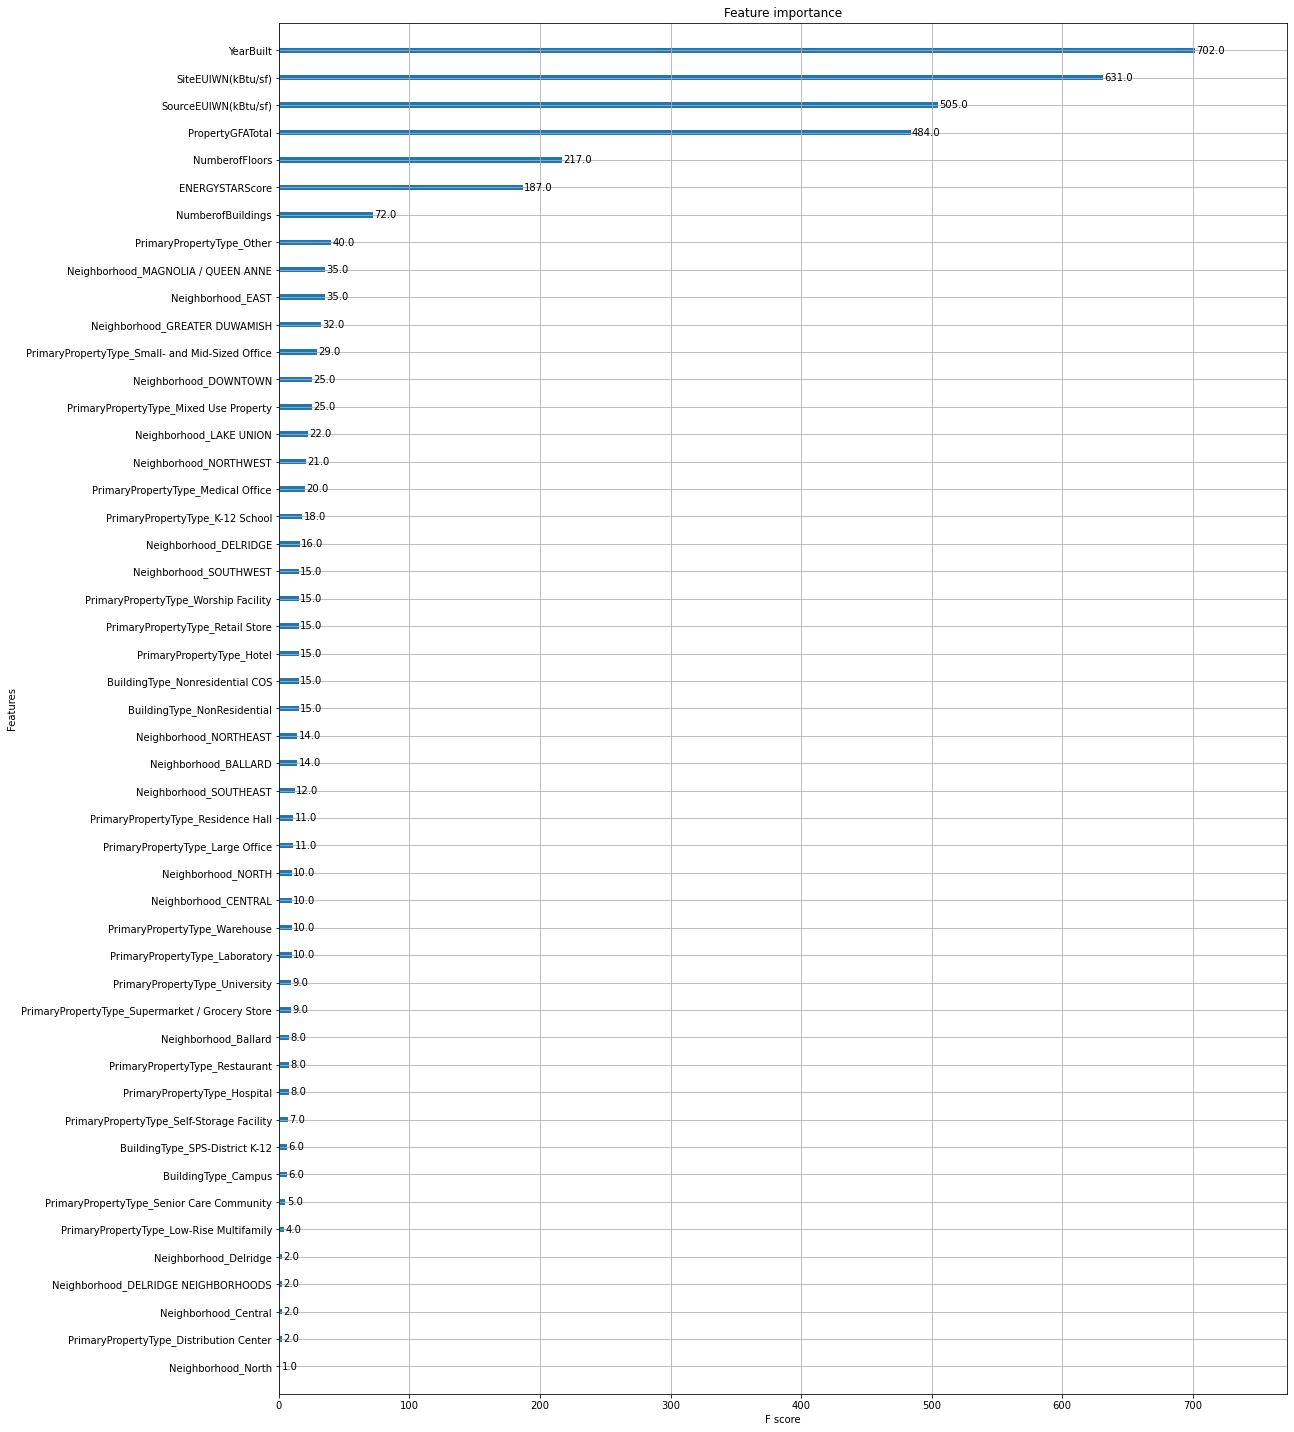

In [30]:
plt.rcParams["figure.figsize"] = (10,8)
plot_importance(xgb_model_2)
plt.subplots_adjust(left=-0.5, bottom=-1.5)
plt.show()

<div class="alert-success">
☛ A significance of 187.0 for the "ENERGYSTARScore" variable suggests that it plays a significant role in model predictions.<br> 
This means that variations in the "ENERGYSTARScore" variable have a significant impact on the values predicted by the XGBoost model.<br>
<strong>We will therefore keep this variable in our model.</strong>
</div>

<a id='another_cell_g'></a> 

### G. Adding variables and combining variables to improve the performance of the chosen model

In [16]:
data_ = pd.read_csv("export_building_energy_bench_data_all.csv", sep=";", index_col=0)

In [17]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1668 entries, 0 to 3375
Data columns (total 42 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1668 non-null   int64  
 1   BuildingType                     1668 non-null   object 
 2   PrimaryPropertyType              1668 non-null   object 
 3   PropertyName                     1668 non-null   object 
 4   Address                          1668 non-null   object 
 5   ZipCode                          1652 non-null   float64
 6   TaxParcelIdentificationNumber    1668 non-null   object 
 7   CouncilDistrictCode              1668 non-null   int64  
 8   Neighborhood                     1668 non-null   object 
 9   Latitude                         1668 non-null   float64
 10  Longitude                        1668 non-null   float64
 11  YearBuilt                        1668 non-null   int64  
 12  NumberofBuildings   

<div class="alert-success">
☛ We have information on the exact position of the building, its year of construction, its characteristics (floors, surface, etc.), its energy star score as well as its total energy consumption and CO2 emissions.<br>
<strong>We will add the following variables to our model to try to improve its performance: "Latitude", "Longitude" and "ListOfAllPropertyUseTypes".</strong>
</div>

In [18]:
# New dataframe augmented with selected data
selected_variables =  ['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes',
    'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
    'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'GHGEmissionsIntensity', 'ENERGYSTARScore']

data_ = data_.loc[:, selected_variables]
data_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1668 entries, 0 to 3375
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OSEBuildingID              1668 non-null   int64  
 1   BuildingType               1668 non-null   object 
 2   PrimaryPropertyType        1668 non-null   object 
 3   ListOfAllPropertyUseTypes  1666 non-null   object 
 4   Neighborhood               1668 non-null   object 
 5   Latitude                   1668 non-null   float64
 6   Longitude                  1668 non-null   float64
 7   YearBuilt                  1668 non-null   int64  
 8   NumberofBuildings          1666 non-null   float64
 9   NumberofFloors             1668 non-null   int64  
 10  PropertyGFATotal           1668 non-null   int64  
 11  SiteEUIWN(kBtu/sf)         1665 non-null   float64
 12  SourceEUIWN(kBtu/sf)       1666 non-null   float64
 13  GHGEmissionsIntensity      1666 non-null   float

<div class="alert-success">
☛ Our dataframe contains 1668 unique buildings and 15 variables now
</div>

In [19]:
# Display null values
null_values = data_[
    data_['SiteEUIWN(kBtu/sf)'].isnull() 
    | data_['SourceEUIWN(kBtu/sf)'].isnull() 
    | data_['GHGEmissionsIntensity'].isnull()]

null_values

,OSEBuildingID,BuildingType,PrimaryPropertyType,ListOfAllPropertyUseTypes,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),GHGEmissionsIntensity,ENERGYSTARScore
563,757,NonResidential,Large Office,"Office, Retail Store",DOWNTOWN,47.61051,-122.34439,1979,1.0,7,131143,NaN,0.0,0.83,93.0
578,773,NonResidential,Small- and Mid-Sized Office,NaN,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,NaN,NaN,NaN,NaN
2670,26532,NonResidential,Mixed Use Property,NaN,NORTHEAST,47.66182,-122.31345,1928,NaN,2,20760,NaN,NaN,NaN,NaN


In [20]:
# Delete rows matching OSE Building IDs in null_values
data_complete = data_.drop(data_[data_['OSEBuildingID'].isin(null_values['OSEBuildingID'])].index)

# Replace Nan values by 0 in "ENERGYSTARScore" variable
data_complete["ENERGYSTARScore"].fillna(0.0, inplace=True)

# Reset indexes after deletion
data_complete = data_complete.reset_index(drop=True)

In [21]:
data_complete = data_complete.drop('OSEBuildingID', axis=1)
data_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1665 non-null   object 
 1   PrimaryPropertyType        1665 non-null   object 
 2   ListOfAllPropertyUseTypes  1665 non-null   object 
 3   Neighborhood               1665 non-null   object 
 4   Latitude                   1665 non-null   float64
 5   Longitude                  1665 non-null   float64
 6   YearBuilt                  1665 non-null   int64  
 7   NumberofBuildings          1665 non-null   float64
 8   NumberofFloors             1665 non-null   int64  
 9   PropertyGFATotal           1665 non-null   int64  
 10  SiteEUIWN(kBtu/sf)         1665 non-null   float64
 11  SourceEUIWN(kBtu/sf)       1665 non-null   float64
 12  GHGEmissionsIntensity      1665 non-null   float64
 13  ENERGYSTARScore            1665 non-null   float

In [24]:
# Categorical data conversion into numerical data (creating a new binary feature for each category)
columns_to_encode = ['BuildingType', 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes', 'Neighborhood']
data_encoded = one_hot_encode_categorical_variables(data_complete, columns_to_encode)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<strong>NB</strong> : Many algorithms generally do not need normalized data. These include decision trees, random forests, naive arrays, gradient boosting, and more.<br>
For consistency with the old process, we will still normalize our data before training our XGBoost model.

In [25]:
# Standardize the data
columns_to_normalize = ['Latitude', 'Longitude','NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'SiteEUIWN(kBtu/sf)',
                        'SourceEUIWN(kBtu/sf)', 'GHGEmissionsIntensity', 'ENERGYSTARScore']

scaler = StandardScaler()
data_encoded[columns_to_normalize] = scaler.fit_transform(data_encoded[columns_to_normalize])

In [26]:
# Scaling the "YearBuild" variable
scaler = MinMaxScaler()
data_encoded['YearBuilt'] = scaler.fit_transform(data_complete['YearBuilt'].values.reshape(-1, 1))

In [27]:
data_encoded.head()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),GHGEmissionsIntensity,ENERGYSTARScore,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,-0.079643,-0.206500,0.234783,-0.057573,1.199873,-0.102490,0.129743,0.058118,0.522803,0.440595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.059511,-0.041382,0.834783,-0.057573,1.047591,-0.051631,0.311062,0.006468,0.535641,0.466434,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.043738,-0.210973,0.600000,-0.057573,5.616052,2.813796,0.308395,0.354565,0.248924,0.001335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.039795,-0.151596,0.226087,-0.057573,0.895309,-0.193621,0.516379,0.246424,1.310203,0.337240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.047474,-0.307360,0.695652,-0.057573,2.113565,0.190410,0.588374,0.201230,0.544199,0.828178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Log transformation of the target variable
data_encoded['GHGEmissionsIntensity'] = np.log(data_encoded['GHGEmissionsIntensity'] + 1)

# Define characteristic values X and target value Y
x3 = data_encoded.drop('GHGEmissionsIntensity', axis=1)
y3 = data_encoded['GHGEmissionsIntensity']

# Dataset splitting (0,75/0,25 by default)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x3, y3, random_state=0)

print("-"*120)
xgb_model_3 = XGBRegressor()
xgb_model_3.fit(x_train_3, y_train_3)
y_pred_xgb_3 = xgb_model_3.predict(x_test_3)
rmse_xgb_3 = mean_squared_error(y_test_3, y_pred_xgb_3, squared=False)
r2_score_xgb_3 = xgb_model_3.score(x_test_3, y_test_3)
print("XGBoost RMSE:", round(rmse_xgb_3, 2))
print("XGBoost R²:", round(r2_score_xgb_3, 2))

------------------------------------------------------------------------------------------------------------------------
XGBoost RMSE: 0.24
XGBoost R²: 0.86


<div class="alert-success">
☛ The performance of our XGBoost model is better with these three new features, especially for the R² which has gone from 0.54 to 0.86.<br>
<strong>Our improved model better explains the variations of our target variable.</strong>
</div>

<a id='another_cell_h'></a> 

### H. Hyperparameter optimization of the selected model

For our XGBoost model, we will use random search as the optimization method on a grid of possible hyperparameters values.<br>
We set the number of iterations to 100 and a division of data into 3 folds.

In [29]:
# Define characteristic values X and target value Y
x4 = data_encoded.drop('GHGEmissionsIntensity', axis=1)
y4 = data_encoded['GHGEmissionsIntensity']

# Dataset splitting (0,75/0,25 by default)
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(x4, y4, random_state=0)

# Define the parameter grid for randomized search
param_dist = {
    'n_estimators': np.arange(100, 1000, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.logspace(-3, 0, num=100),
    'subsample': np.linspace(0.5, 1, num=50),
    'colsample_bytree': np.linspace(0.5, 1, num=50),
    'min_child_weight': np.arange(1, 10),
    'gamma': np.arange(0, 5)
}

print("-"*120)
xgb_model_4 = XGBRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_mean_squared_error',  # Use negative RMSE for optimization
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Perform the randomized search
random_search.fit(x_train_4, y_train_4)

# Get the best estimator from the search
best_xgb_model = random_search.best_estimator_

# Evaluate the best model
y_pred_best = best_xgb_model.predict(x_test_4)
rmse_best = mean_squared_error(y_test_4, y_pred_best, squared=False)
r2_score_best = best_xgb_model.score(x_test_4, y_test_4)
print("Best XGBoost RMSE:", round(rmse_best, 2))
print("Best XGBoost R²:", round(r2_score_best, 2))

------------------------------------------------------------------------------------------------------------------------
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best XGBoost RMSE: 0.2
Best XGBoost R²: 0.9


<div class="alert-success">
☛ <strong>The performance of our XGBoost model is even better after optimizing its hyperparameters.</strong>
</div>

<a id='another_cell_i'></a> 

### I. Explain Predictions using SHAP Values

In [41]:
# Initialize the SHAP explainer with the trained XGBoost model
explainer = shap.Explainer(best_xgb_model, x_train_4)

# Explain a single prediction (for example, the first instance in the test set)
sample_idx = 0
shap_values_single = explainer.shap_values(x_test_4.iloc[sample_idx])

# Print the SHAP values for the prediction
print("SHAP Values for the sample:")
print(shap_values_single)

# Plot the SHAP force plot for the sample
shap.force_plot(explainer.expected_value, shap_values_single, x_test_4.iloc[sample_idx])

SHAP Values for the sample:
[-2.02040794e-02  1.46049396e-02 -4.08657708e-03 -5.75775673e-03
  1.29227944e-03 -1.06194424e-02 -3.74469503e-01 -1.74637718e-01
  1.43865177e-03 -4.84659166e-04 -3.86709228e-04  8.08341923e-06
  0.00000000e+00 -4.78994652e-04 -1.11870401e-05  0.00000000e+00
 -3.72380233e-04 -2.43972300e-03 -5.73543129e-04  1.04374140e-03
  0.00000000e+00 -6.74840218e-04  1.56165092e-03  0.00000000e+00
 -3.23085343e-04  1.38577202e-05 -3.51148799e-04 -1.30040567e-03
 -5.56194584e-05  3.66579855e-05 -5.30759957e-04 -3.36991194e-03
  1.00732840e-03 -6.85190014e-05  8.23542403e-04 -1.65585859e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  8.23299051e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+

<div class="alert-success">
☛ For the first instance of our dataset test, we notice that the variables "Site energy use intensive weather normalized", "Source energy use intensive weather normalized" and "Latitude" have been negatively affected in the prediction.
</div>

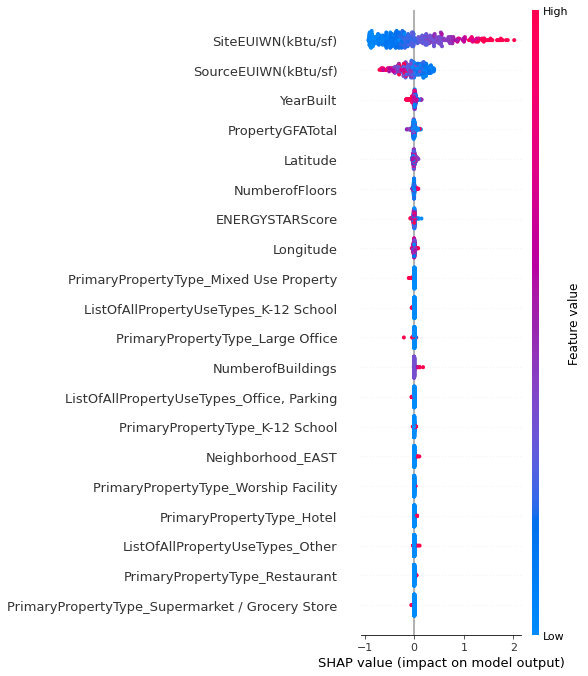

In [42]:
# Explain all predictions in the test set
shap_values = explainer.shap_values(x_test_4)

# Summary plot for the entire test set
shap.summary_plot(shap_values, x_test_4)

<div class="alert-success">
☛ We see here that <strong>the energy consumption variables as well as the year of construction, the surface, the latitude, the longitude, the number of floors and buildings, the energy star score as well as the categorical variables related to the use building history have a significant influence on the prediction of their CO2 emissions.</strong>
</div>

<a id='another_cell_j'></a> 

### Conclusion (part 2)

<div class="alert-success">
To predict the CO2 emissions of our buildings :<br>
<i>→ we tested several prediction models and evaluated their performance ;<br>
→ we performed a logarithmic transformation of our target variable to improve the performance of our models, and selected the best (here our XGBoost model) ;<br>
→ we have improved the performance of the selected model by adding new features in the training data and optimizing the selection of its hyperparameters ;<br>
→ we have found that the energy star score, like almost all of the features used to predict our data, have a real influence on our results.</i><br>
</div>